*Copyright (C) 2021 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

# PIPG ANYmal Dataset Profiling 

### PIPG to solve QPs on Loihi

Consider a QP of the following form:
$$ \text{argmin} \frac{1}{2}x^TQx + p^Tx $$
$$ \text{s.t.  } Ax = k,$$
$$ l \le x \le u $$
where $ x \in \mathbb{R}^n$, $ Q \in \mathbb{S}_{+}^{n \times n}$, $ p \in \mathbb{R}^n$ , $ A \in \mathbb{R}^{m \times n} $ and $ k \in \mathbb{R}^m$ where $m$ and $n$ are integers. $l$ and $u$ are lower and upper bounds on the variable x. This can be solved with the following first-order iterative update scheme,

$$ v_j = w_j + \beta_j \cdot (Ax_j - k) $$
$$ x_{j+1} = \pi_{X}(x_j - \alpha_j \cdot (Qx_j + p + A^Tv_j)) $$
$$ w_{j+1} = w_j + \beta_j \cdot (Ax_{j+1} - k) $$

The learning rates are given by:
$$ \alpha_k = \frac{2}{(k+1)\cdot\mu + 2\lambda} \text{ and } \beta_k = \frac{(k+1)\cdot\mu}{2\sigma}$$
where $ \mu I \le Q \le \lambda I$ and $ A^TA \le \sigma I$
The above equations can be reduced to the following process models in Lava 

we assume no bounds on the variable $x$ and therefore in the above equations, $\pi_X(x) = \text{min}(\text{max}(x, - \infty), \infty) = x$

In [1]:
import numpy as np
from scipy.spatial import distance
from scipy import sparse
import matplotlib.pyplot as plt
import time
import os
import osqp

### Function Calls

In [2]:
def ruiz_equilibriation(matrix, iterations):
    #tic = time.time()
    m_bar = matrix 
    left_preconditioner = sparse.csc_matrix(np.eye(matrix.shape[0]))
    right_preconditioner = sparse.csc_matrix(np.eye(matrix.shape[1]))
    row_del, col_del = 0, 0
    for i in range(iterations):
        D_l_inv = sparse.csc_matrix(np.diag(1/np.sqrt(np.linalg.norm(m_bar, ord=2, axis=1))))
        if(m_bar.shape[0] != m_bar.shape[1]):
            D_r_inv = sparse.csc_matrix(np.diag(1/np.sqrt(np.linalg.norm(m_bar, ord=2, axis=0))))
        else:
            D_r_inv = D_l_inv
            
        m_bar = D_l_inv@m_bar@D_r_inv
        left_preconditioner = left_preconditioner@D_l_inv
        #right_preconditioner = right_preconditioner@D_r_inv
        row_del = np.max(np.abs(1-np.linalg.norm(m_bar, ord=2, axis=1))) 
    print(row_del)
    #print(time.time()-tic)
    return left_preconditioner, right_preconditioner

In [3]:
def alpha_pipg(mu, lamda):
    return 2/(mu + 2*lamda)

def beta_pipg(sigma):
    return mu/(2*sigma)

def projection_box_constraints(x,l=None,u=None, projection='no'):
    if projection=='no':
        return x
    else:
        return np.clip(x, l, u)

### Run PIPG Analyses on all files in dataset

In [4]:
scale = "small"
path = "qp/data/anymal_"+scale+"_scale/"
file_list=os.listdir(path)

multi_prob_per_sol_error = []
alpha_decay_indices_list = [35, 100, 200, 350, 600, 900]
beta_growth_indices_list = [1, 3, 7, 15, 31, 63, 127, 255, 511, 900]

k_max = 1000

for file in file_list:
    a = np.load(path+file)
    Q, A, p, k = [a[i] for i in a] 
    
    # OSQP reference
    Q_ref = sparse.csc_matrix(Q)
    A_ref = sparse.csc_matrix(A)
    l_eq = k
    u_eq = k
    #create OSQP object
    prob = osqp.OSQP()
    prob.setup(Q_ref, p, A_ref, l_eq, u_eq, warm_start=False)
    res = prob.solve()
    opt_sol = res.x.reshape((res.x.shape[0], 1))
    opt_objective =  res.info.obj_val
    
    toc = time.time()
    
    # matrix preconditioning
    pre_mat_Q, _ = ruiz_equilibriation(Q, 20)
    Q_pre = pre_mat_Q@Q@pre_mat_Q
    p_pre = pre_mat_Q@p

    pre_mat_A, _ = ruiz_equilibriation(A, 10)
    A_pre = pre_mat_A@A@pre_mat_Q
    k_pre = pre_mat_A@k
    
    # PIPG starts here
    # PIPG constants
    mu, sigma, lamda =  0.11, 8.14, 1.6
    alpha_lava = alpha_pipg(mu, lamda)
    beta_lava = beta_pipg(sigma)
    
    # PIPG init
    np.random.seed(10)
    w = np.random.rand(A.shape[0],1) 
    z = np.random.rand(A.shape[1],1)
    v= np.random.rand(A.shape[0],1)
    
    sol = []
    constraint_sat = []
    cost = []
    
    for i in range(k_max):
        if (i in alpha_decay_indices_list ):
            alpha_lava/=2
        if (i in beta_growth_indices_list):
            beta_lava*=2

        z = projection_box_constraints(z - alpha_lava * (Q_pre@z + p_pre + A_pre.T@v))
        w = w + beta_lava * (A_pre@z - k_pre)
        v = w + beta_lava * (A_pre@z - k_pre)
        
        #cost.append(np.abs((z.T@H_pre@z/2 + h_pre.T@z) - opt_objective)/np.abs(opt_objective)*100)
        sol.append(pre_mat_Q@z)
        #constraint_sat.append(np.linalg.norm(G_pre@z - g_pre))
    cons_vio = [np.linalg.norm(A@s - k) for s in sol]
    err_sol = [np.linalg.norm(res.x.reshape((res.x.shape[0], 1)) - s) for s in sol]
    err_sol_percent = [np.linalg.norm(opt_sol - s)/np.linalg.norm(opt_sol)*100 for s in sol] 
#     print("Found solution in {} seconds with error of {}% and constraint violation {}".format(
#         time.time()- toc, err_sol_percent[-1]), np.linalg.norm(A@sol[-1]-k))
    multi_prob_per_sol_error.append(cons_vio)

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 264, constraints m = 144
          nnz(P) + nnz(A) = 1264
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: off, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.0288e+04   3.33e-02   1.81e+00   1.00e-01   5.92e-04s
  25  -1.6021e+04   2.90e-06   8.49e-06   1.00e-01   1.07e-03s

status:               solved
number of ite

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 264, constraints m = 144
          nnz(P) + nnz(A) = 1471
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: off, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -3.2164e+05   1.51e-01   9.35e+00   1.00e-01   8.02e-04s
  25  -5.0055e+05   1.75e-05   4.49e-05   1.00e-01   1.27e-03s

status:               solved
number of ite

### Plot all solution errors

In [5]:
error_data = np.array(multi_prob_per_sol_error)
std_err = np.std(error_data, axis=0)
mean_err = np.mean(error_data, axis=0)
min_err = np.min(error_data, axis=0)
max_err = np.max(error_data, axis=0) 

Text(0.5, 0, 'Iterations')

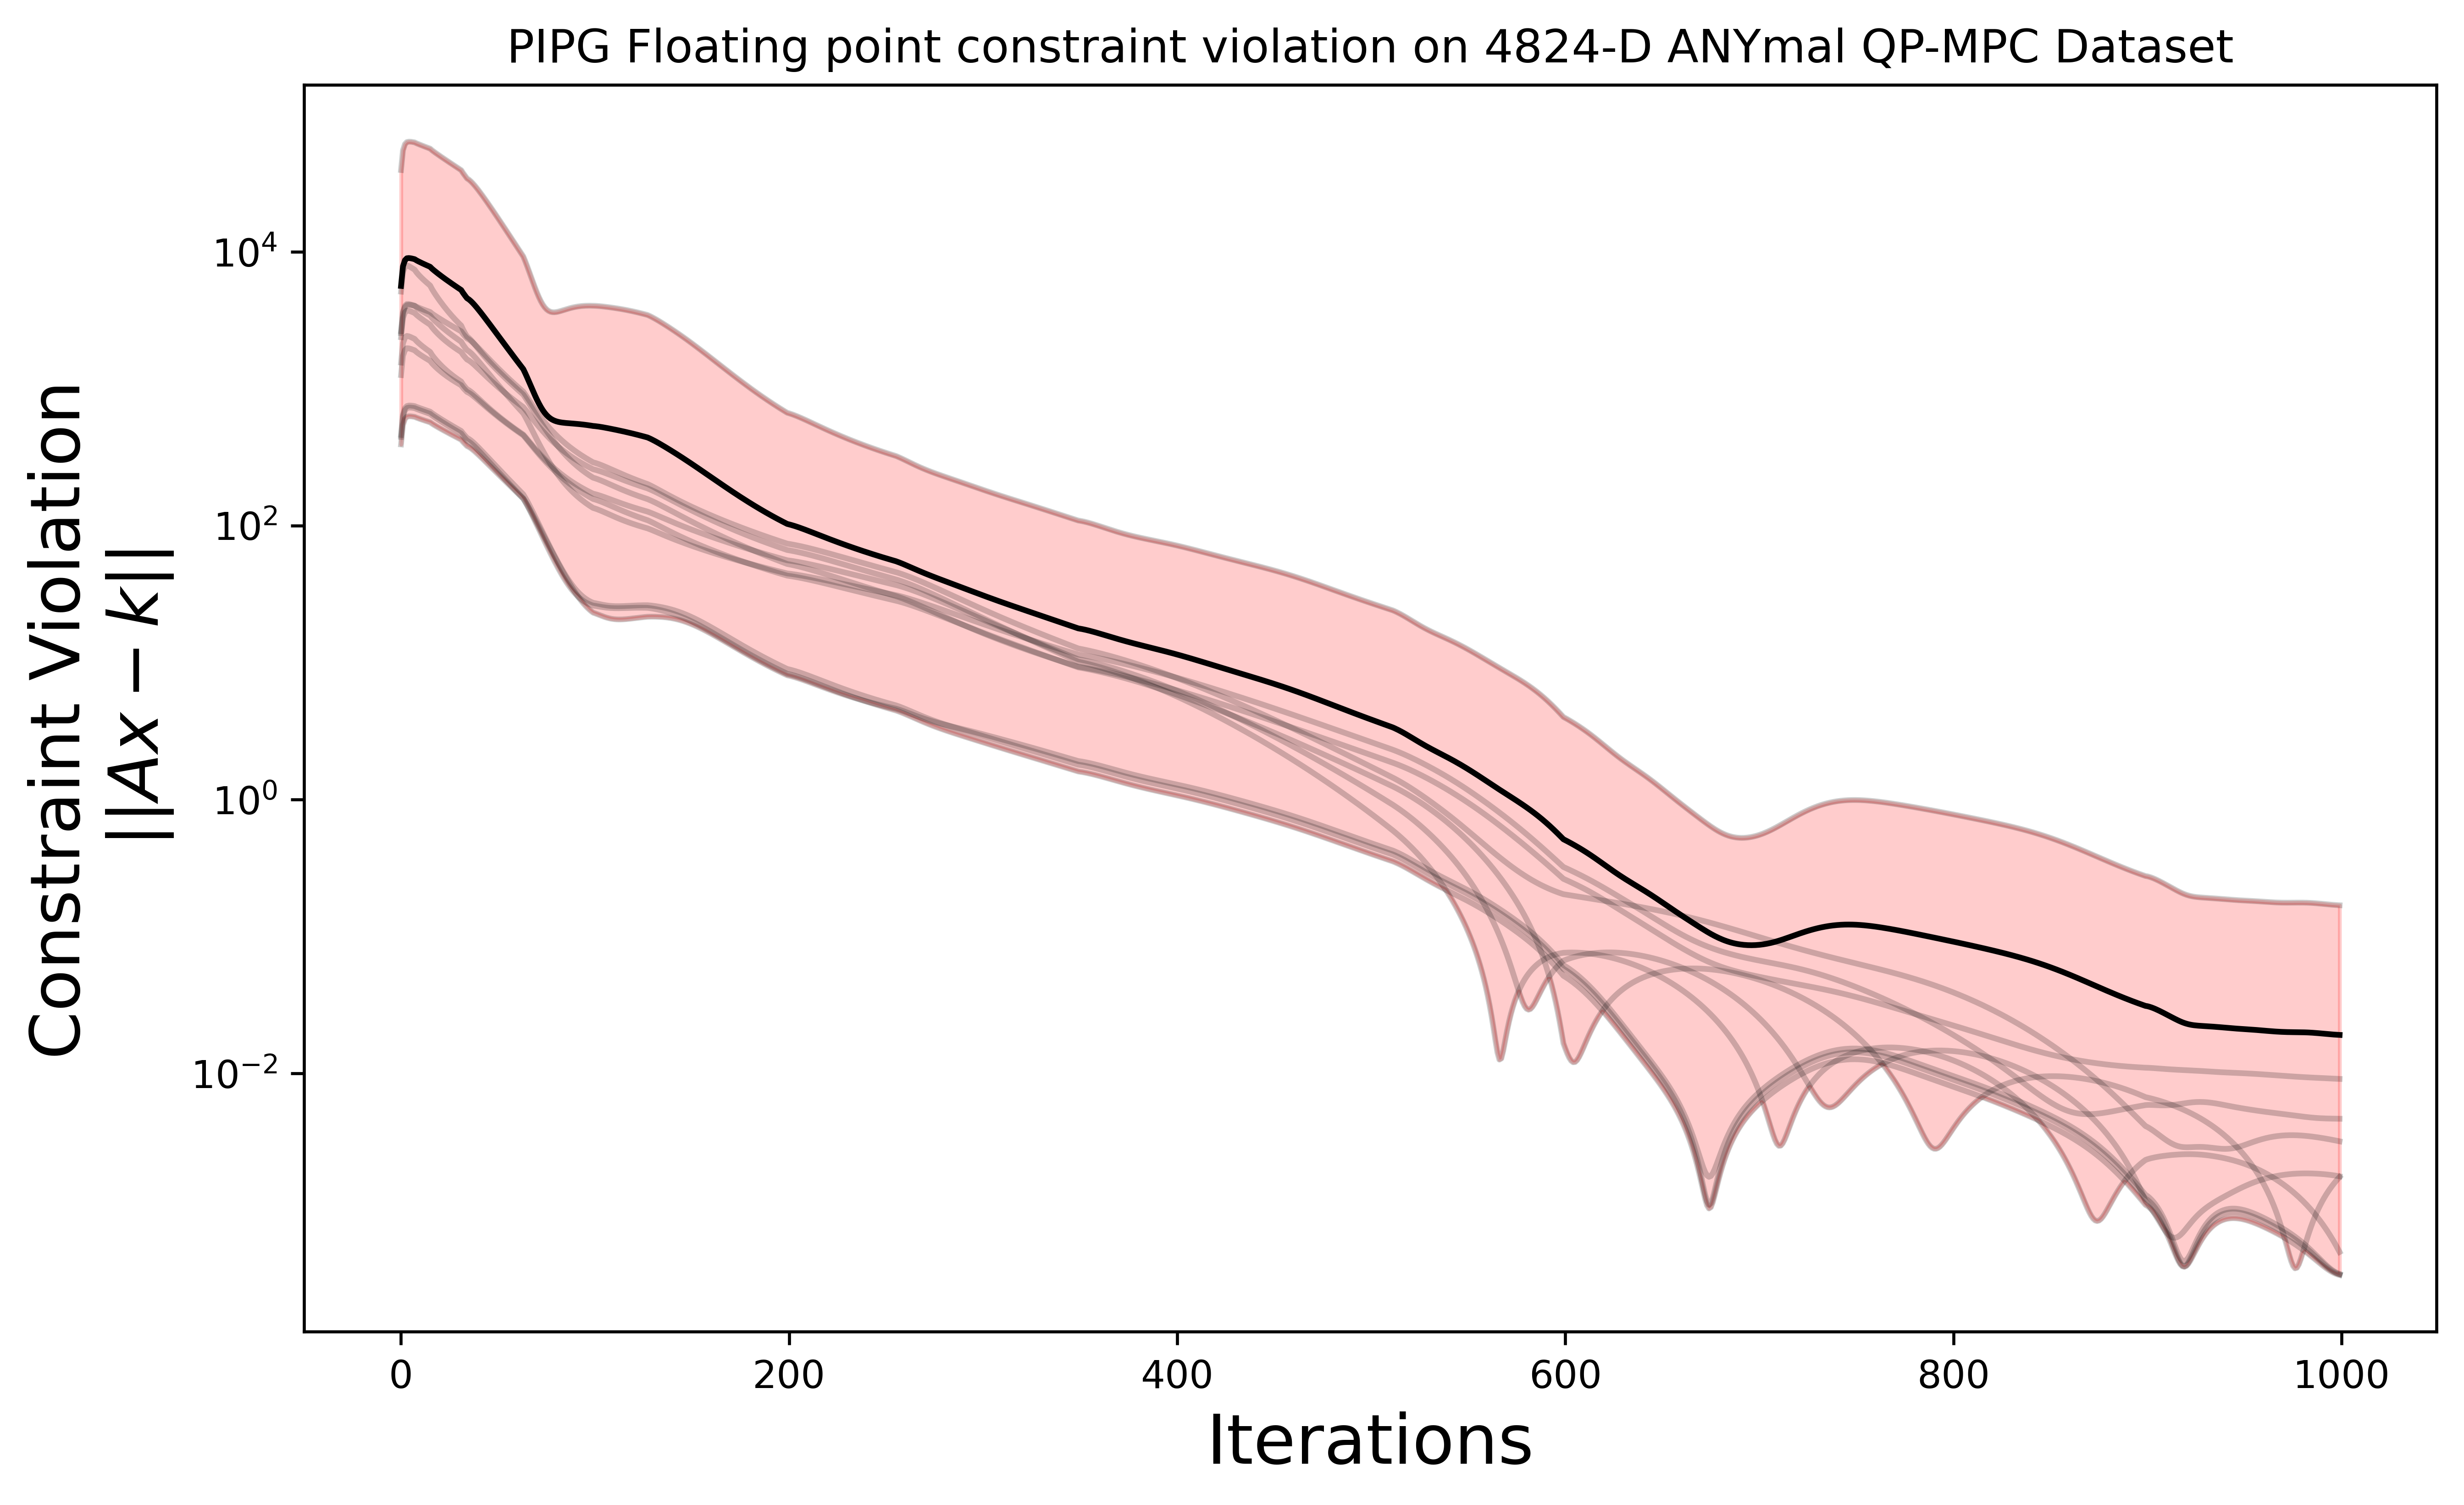

In [6]:
fig,ax = plt.subplots(figsize=(10, 6), dpi=600)
plt.rcParams.update({'font.size': 14})
# plt.title("PIPG convergence to solution on 4824-D ANYmal QP-MPC Dataset", fontsize=14)
plt.title("PIPG Floating point constraint violation on 4824-D ANYmal QP-MPC Dataset", fontsize=12)
# ax.plot(np.array(cost)[:,0,0], color="red", label="PIPG")
# ax.set_ylabel(" Objective Percentage error ",color="red",fontsize=18)
for error in multi_prob_per_sol_error:
    ax.plot(error[:], color='black', alpha=0.2)
ax.fill_between(range(0,k_max), min_err, max_err, color='red', alpha=0.2)
ax.plot(mean_err, color='black')
#ax.vlines(750, 0, 100, colors='black', linestyles='dotted', label='3 ms')

# ax.plot(mean_err)
# ax.plot(mean_err+std_err)

# ax.set_ylabel("\n $ ||x*-x||_2/||x*||_2} $ *100",color="blue",fontsize=18)
ax.set_ylabel("Constraint Violation \n $ ||Ax-k||} $",color="black",fontsize=18)
ax.set_yscale('log')
#ax.set_ylim([0,100])

#ax.legend(loc="upper right", fontsize='xx-large')

# set x-axis label
ax.set_xlabel("Iterations",fontsize=18)

### Lava PIPG Sparsification analysis

Now we put things together and run the PIPG solver in Lava

In [7]:
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.lib.optimization.solvers.qp.models import (
    ConstraintDirections,
    ConstraintNormals,
    QuadraticConnectivity,
    ProjectedGradientNeuronsPIPGeq,
    ProportionalIntegralNeuronsPIPGeq,
    SigmaNeurons,
    DeltaNeurons
)

In [8]:
scale = "small"

In [9]:
path = "qp/data/anymal_"+scale+"_scale/"
file_list=os.listdir(path)

In [10]:
multi_prob_grad_dir_ct = []
multi_prob_grad_dir_at = []

multi_prob_accuracy_red_ct = []
multi_prob_accuracy_red_at = []

multi_prob_relative_ops_ct = []
multi_prob_relative_ops_at = []


alpha_decay_indices_list = [35, 100, 200, 350, 600, 900]
beta_growth_indices_list = [1, 3, 7, 15, 31, 63, 127, 255, 511, 900]

iterations = 750

for file in file_list:
    a = np.load(path+file)
    Q, A, p, k = [a[i] for i in a] 
    
    # OSQP reference
    Q_ref = sparse.csc_matrix(Q)
    A_ref = sparse.csc_matrix(A)
    l_eq = k
    u_eq = k
    #create OSQP object
    prob = osqp.OSQP()
    prob.setup(Q_ref, p, A_ref, l_eq, u_eq, warm_start=False)
    res = prob.solve()
    opt_sol = res.x.reshape((res.x.shape[0], 1))
    opt_objective =  res.info.obj_val
    
    toc = time.time()
    
    # matrix preconditioning
    pre_mat_Q, _ = ruiz_equilibriation(Q, 10)
    Q_pre = pre_mat_Q@Q@pre_mat_Q
    p_pre = pre_mat_Q@p

    pre_mat_A, _ = ruiz_equilibriation(A, 10)
    A_pre = pre_mat_A@A@pre_mat_Q
    k_pre = pre_mat_A@k
    
    # PIPG starts here
    # PIPG constants
    mu, sigma, lamda =  0.11, 8.14, 1.6

       
    # Reference solution run 
    ProjGrad = ProjectedGradientNeuronsPIPGeq(shape=p_pre.shape, 
                                           qp_neurons_init=np.random.rand(p_pre.shape[0], 1),
                                           grad_bias=p_pre,
                                           alpha=alpha_pipg(mu, lamda),
                                           lr_decay_type = 'indices',
                                           alpha_decay_indices = alpha_decay_indices_list)

    ProInt = ProportionalIntegralNeuronsPIPGeq(shape=k_pre.shape, 
                                               constraint_neurons_init=np.random.rand(k_pre.shape[0], 1),
                                               thresholds=k_pre,
                                               beta=beta_pipg(sigma),
                                               lr_growth_type = 'indices',
                                               beta_growth_indices = beta_growth_indices_list 
                                               )

    # Connection Processes
    ConsDir = ConstraintDirections(shape=A_pre.shape, constraint_directions=A_pre)
    ConsNorm = ConstraintNormals(shape=A_pre.T.shape, constraint_normals=A_pre.T)
    QuadConn = QuadraticConnectivity(shape=Q_pre.shape, hessian=Q_pre)

    # Connecting Processes together
    QuadConn.a_out.connect(ProjGrad.a_in_qc)
    ConsNorm.a_out.connect(ProjGrad.a_in_cn)
    ProjGrad.s_out_qc.connect(QuadConn.s_in)
    ProjGrad.s_out_cd.connect(ConsDir.s_in)
    ConsDir.a_out.connect(ProInt.a_in)
    ProInt.s_out.connect(ConsNorm.s_in)
    
    # Run solver dynamics QP
    toc = time.time()
    ProjGrad.run(condition=RunSteps(num_steps=iterations),
                          run_cfg=Loihi1SimCfg()
                         )
    
    # get pre-conditioned solution 
    pre_sol_k = ProjGrad.vars.qp_neuron_state.get()
    
    # Profiling data
    tot_synops = QuadConn.vars.synops.get() + ConsNorm.vars.synops.get() + ConsDir.vars.synops.get()
    tot_spikeops = ProInt.vars.spikeops.get() + ProjGrad.vars.spikeops.get() 

    # stop process execution
    ProjGrad.stop()

    tic = time.time()

    # postconditioning to get actual solution
    sol_k =  pre_mat_Q@pre_sol_k
    print("Solution in {} seconds with constraint violation {}".format(tic-toc, np.linalg.norm(A@sol_k-k)))

    print("For reference, number of operations per iteration \n Syn Ops: {} \n Spike Ops: {}\n".format( 
                                                                                     tot_synops/iterations, tot_spikeops/iterations))
    ref_grad = -(Q_pre@pre_sol_k + p_pre) 
    ref_sol = (pre_mat_Q@pre_sol_k).copy()
    ref_synops = tot_synops.copy()
    
    ################################ Constant Thresholding Sigma Delta ####################################################
    thetas = [0, 0.001, 0.01, 0.2, 0.5]
    
    accuracies_ct = []
    relative_ops_ct = []
    grad_sim_ct = []

    np.random.seed(10)
    qp_init = np.random.rand(p_pre.shape[0], 1)
    
    for theta in thetas:
        ProjGrad = ProjectedGradientNeuronsPIPGeq(shape=p_pre.shape, 
                                               qp_neurons_init=qp_init,
                                               grad_bias=p_pre,
                                               alpha=alpha_pipg(mu, lamda),
                                               lr_decay_type = 'indices',
                                               alpha_decay_indices = alpha_decay_indices_list)

        ProInt = ProportionalIntegralNeuronsPIPGeq(shape=k_pre.shape, 
                                                   constraint_neurons_init=np.random.rand(k_pre.shape[0], 1),
                                                   thresholds=k_pre,
                                                   beta=beta_pipg(sigma),
                                                   lr_growth_type = 'indices',
                                                   beta_growth_indices = beta_growth_indices_list 
                                                   )


        # Connection Processes
        ConsDir = ConstraintDirections(shape=A_pre.shape, constraint_directions=A_pre)
        ConsNorm = ConstraintNormals(shape=A_pre.T.shape, constraint_normals=A_pre.T)
        QuadConn = QuadraticConnectivity(shape=Q_pre.shape, hessian=Q_pre)

        # Delta Neuron process, same initial value as qp_init
        # theta_decay_schedule set to 10000 to maintain constant theta till 10000 iterations
        delNeur = DeltaNeurons(shape=qp_init.shape,
                               x_del_init=qp_init,
                               theta=theta,
                               theta_decay_schedule=10000,
                                )
    

        QuadConn.a_out.connect(ProjGrad.a_in_qc)
        ConsNorm.a_out.connect(ProjGrad.a_in_cn)

        ProjGrad.s_out_qc.connect(delNeur.s_in)
        delNeur.s_out.connect(QuadConn.s_in)


        delNeur.s_out.connect(ConsDir.s_in)
        ConsDir.a_out.connect(ProInt.a_in)
        ProInt.s_out.connect(ConsNorm.s_in)

        
        # Run solver dynamics QP
        toc = time.time()
        ProjGrad.run(condition=RunSteps(num_steps=iterations),
                              run_cfg=Loihi1SimCfg()
                             )

        # get pre-conditioned solution 
        pre_sol_k_ct = ProjGrad.vars.qp_neuron_state.get()

        # Profiling data for constant theta
        tot_synops_ct = QuadConn.vars.synops.get() + ConsNorm.vars.synops.get() + ConsDir.vars.synops.get()
        tot_spikeops_ct = ProInt.vars.spikeops.get() + delNeur.vars.spikeops.get() 

        # stop process execution
        ProjGrad.stop()

        grad_ct = -(Q_pre@pre_sol_k_ct + p_pre) 
        print("Finished calcuations for constant theta={} in {} seconds with constraint violation {}".format(
            theta, time.time()-toc,np.linalg.norm(A@(pre_mat_Q@pre_sol_k_ct)-k)))

        # Append stats for constant theta to a list
        grad_sim_ct.append(distance.cosine(ref_grad.reshape(ref_grad.shape[0],), grad_ct.reshape(grad_ct.shape[0],)))
        accuracies_ct.append(np.linalg.norm(ref_sol - (pre_mat_Q@pre_sol_k_ct))/np.linalg.norm(ref_sol)*100)
        relative_ops_ct.append((ref_synops/tot_synops_ct).squeeze(axis=0))
        print("For constant theta={} number of operations per iteration \n Syn Ops: {} \n Spike Ops: {}\n".format(theta, 
                                                                                         tot_synops_ct/iterations, tot_spikeops_ct/iterations))
      
        multi_prob_grad_dir_ct.append(grad_sim_ct)
        multi_prob_accuracy_red_ct.append(accuracies_ct)
        multi_prob_relative_ops_ct.append(relative_ops_ct)
        
    ############################ Adaptive Thresholding Sigma Delta ####################################################
    thetas = [0, 0.2, 0.5, 1, 2, 10, 20, 40]
    accuracies_at = []
    relative_ops_at = []
    grad_sim_at = []


    np.random.seed(10)
    qp_init = np.random.rand(p_pre.shape[0], 1)

    for theta in thetas:
    # Reference solution run 
        ProjGrad = ProjectedGradientNeuronsPIPGeq(shape=p_pre.shape, 
                                               qp_neurons_init=qp_init,
                                               grad_bias=p_pre,
                                               alpha=alpha_pipg(mu, lamda),
                                               lr_decay_type = 'indices',
                                               alpha_decay_indices = alpha_decay_indices_list)

        ProInt = ProportionalIntegralNeuronsPIPGeq(shape=k_pre.shape, 
                                                   constraint_neurons_init=np.random.rand(k_pre.shape[0], 1),
                                                   thresholds=k_pre,
                                                   beta=beta_pipg(sigma),
                                                   lr_growth_type = 'indices',
                                                   beta_growth_indices = beta_growth_indices_list 
                                                   )


        # Connection Processes
        ConsDir = ConstraintDirections(shape=A_pre.shape, constraint_directions=A_pre)
        ConsNorm = ConstraintNormals(shape=A_pre.T.shape, constraint_normals=A_pre.T)
        QuadConn = QuadraticConnectivity(shape=Q_pre.shape, hessian=Q_pre)

        # Delta Neuron process, same initial value as qp_init
        # theta_decay_schedule set to 50 
    #     delNeur = DeltaNeurons(shape=qp_init.shape,
    #                            x_del_init=qp_init,
    #                            theta=theta,
    #                            theta_decay_type = 'indices',
    #                            theta_decay_indices = alpha_decay_indices_list
    #                             )
        delNeur = DeltaNeurons(shape=qp_init.shape,
                           x_del_init=qp_init,
                           theta=theta,
                           theta_decay_schedule = 40
                            )

        # Connecting Processes together, adding sparsifying processes in between
        QuadConn.a_out.connect(ProjGrad.a_in_qc)
        ConsNorm.a_out.connect(ProjGrad.a_in_cn)

        ProjGrad.s_out_qc.connect(delNeur.s_in)
        delNeur.s_out.connect(QuadConn.s_in)


        delNeur.s_out.connect(ConsDir.s_in)
        ConsDir.a_out.connect(ProInt.a_in)
        ProInt.s_out.connect(ConsNorm.s_in)

        # Run solver dynamics QP
        toc = time.time()
        ProjGrad.run(condition=RunSteps(num_steps=iterations),
                              run_cfg=Loihi1SimCfg()
                             )

        # get pre-conditioned solution 
        pre_sol_k_at = ProjGrad.vars.qp_neuron_state.get()

        # Profiling data for constant theta
        tot_synops_at = QuadConn.vars.synops.get() + ConsNorm.vars.synops.get() + ConsDir.vars.synops.get()
        tot_spikeops_at = ProInt.vars.spikeops.get() + delNeur.vars.spikeops.get() 

        # stop process execution
        ProjGrad.stop()

        grad_at = -(Q_pre@pre_sol_k_at + p_pre) 
        print("Finished calcuations for adaptive theta={} in {} seconds with constraint violation {}".format(
            theta, time.time()-toc, np.linalg.norm(A@(pre_mat_Q@pre_sol_k_at)-k)))

        # Append stats for constant theta to a list
        grad_sim_at.append(distance.cosine(ref_grad.reshape(ref_grad.shape[0],), grad_at.reshape(grad_at.shape[0],)))
        accuracies_at.append(np.linalg.norm(ref_sol - (pre_mat_Q@pre_sol_k_at))/np.linalg.norm(ref_sol)*100)
        relative_ops_at.append((ref_synops/tot_synops_at).squeeze(axis=0))
        print("For adaptive theta={} number of operations per iteration \n Syn Ops: {} \n Spike Ops: {}\n".format(theta, 
                                                                                         tot_synops_at/iterations, tot_spikeops_at/iterations))    
        multi_prob_grad_dir_at.append(grad_sim_at)
        multi_prob_accuracy_red_at.append(accuracies_at)
        multi_prob_relative_ops_at.append(relative_ops_at)

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 264, constraints m = 144
          nnz(P) + nnz(A) = 1264
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: off, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.0288e+04   3.33e-02   1.81e+00   1.00e-01   1.62e-03s
  25  -1.6021e+04   2.90e-06   8.49e-06   1.00e-01   2.36e-03s

status:               solved
number of ite

Finished calcuations for adaptive theta=20 in 6.3169074058532715 seconds with constraint violation 24.144467892288784
For adaptive theta=20 number of operations per iteration 
 Syn Ops: [[1629.32666667]] 
 Spike Ops: [[286.37333333]]

Finished calcuations for adaptive theta=40 in 5.747151613235474 seconds with constraint violation 17.858881500554215
For adaptive theta=40 number of operations per iteration 
 Syn Ops: [[1577.148]] 
 Spike Ops: [[276.848]]

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 264, constraints m = 144
          nnz(P) + nnz(A) = 1317
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho 

Finished calcuations for adaptive theta=10 in 4.993557453155518 seconds with constraint violation 14.676600706281633
For adaptive theta=10 number of operations per iteration 
 Syn Ops: [[1907.88]] 
 Spike Ops: [[317.77066667]]

Finished calcuations for adaptive theta=20 in 4.549076080322266 seconds with constraint violation 12.99555732869025
For adaptive theta=20 number of operations per iteration 
 Syn Ops: [[1826.976]] 
 Spike Ops: [[305.98533333]]

Finished calcuations for adaptive theta=40 in 4.814527273178101 seconds with constraint violation 65.52702698972209
For adaptive theta=40 number of operations per iteration 
 Syn Ops: [[1741.51466667]] 
 Spike Ops: [[293.20533333]]

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  va

Finished calcuations for adaptive theta=2 in 12.054426431655884 seconds with constraint violation 335.86456458015215
For adaptive theta=2 number of operations per iteration 
 Syn Ops: [[2497.312]] 
 Spike Ops: [[377.984]]

Finished calcuations for adaptive theta=10 in 14.60610318183899 seconds with constraint violation 98.12421862639417
For adaptive theta=10 number of operations per iteration 
 Syn Ops: [[2384.732]] 
 Spike Ops: [[362.00933333]]

Finished calcuations for adaptive theta=20 in 10.376678466796875 seconds with constraint violation 340.78574780905615
For adaptive theta=20 number of operations per iteration 
 Syn Ops: [[2323.39466667]] 
 Spike Ops: [[353.54]]

Finished calcuations for adaptive theta=40 in 14.663299322128296 seconds with constraint violation 841.8891044676285
For adaptive theta=40 number of operations per iteration 
 Syn Ops: [[2256.98133333]] 
 Spike Ops: [[344.3]]

-----------------------------------------------------------------
           OSQP v0.6.2  -  

Finished calcuations for adaptive theta=1 in 7.057421445846558 seconds with constraint violation 5.2725300099260055
For adaptive theta=1 number of operations per iteration 
 Syn Ops: [[2264.70266667]] 
 Spike Ops: [[355.50133333]]

Finished calcuations for adaptive theta=2 in 5.407429218292236 seconds with constraint violation 90.36036254019673
For adaptive theta=2 number of operations per iteration 
 Syn Ops: [[2198.528]] 
 Spike Ops: [[346.568]]

Finished calcuations for adaptive theta=10 in 5.474867343902588 seconds with constraint violation 43.646511871376205
For adaptive theta=10 number of operations per iteration 
 Syn Ops: [[2021.808]] 
 Spike Ops: [[321.424]]

Finished calcuations for adaptive theta=20 in 6.496899366378784 seconds with constraint violation 12.876781714672386
For adaptive theta=20 number of operations per iteration 
 Syn Ops: [[1938.20533333]] 
 Spike Ops: [[309.78133333]]

Finished calcuations for adaptive theta=40 in 9.981637716293335 seconds with constraint v

Finished calcuations for adaptive theta=0.5 in 5.602586507797241 seconds with constraint violation 13.61475526448985
For adaptive theta=0.5 number of operations per iteration 
 Syn Ops: [[2319.568]] 
 Spike Ops: [[364.14666667]]

Finished calcuations for adaptive theta=1 in 7.399562358856201 seconds with constraint violation 16.60970517545793
For adaptive theta=1 number of operations per iteration 
 Syn Ops: [[2262.78266667]] 
 Spike Ops: [[356.06133333]]

Finished calcuations for adaptive theta=2 in 6.5348899364471436 seconds with constraint violation 38.38481011669229
For adaptive theta=2 number of operations per iteration 
 Syn Ops: [[2203.06533333]] 
 Spike Ops: [[347.67733333]]

Finished calcuations for adaptive theta=10 in 5.807787179946899 seconds with constraint violation 42.60802582789975
For adaptive theta=10 number of operations per iteration 
 Syn Ops: [[2034.39333333]] 
 Spike Ops: [[324.37866667]]

Finished calcuations for adaptive theta=20 in 5.100325107574463 seconds wi

In [11]:
# # Save Data 
# import pickle
# open_file = open('qp/data/op_stats_sigma_delta_' + scale + '_' + str(iterations), "wb")
# pickle.dump(multi_prob_accuracy_red_at, open_file)
# pickle.dump(multi_prob_accuracy_red_ct, open_file)
# pickle.dump(multi_prob_grad_dir_at, open_file)
# pickle.dump(multi_prob_grad_dir_ct, open_file)
# pickle.dump(multi_prob_relative_ops_at, open_file)
# pickle.dump(multi_prob_relative_ops_ct, open_file)
# open_file.close()

In [12]:
# scale='full'
# iterations = 750
# open_file = open('qp/data/op_stats_sigma_delta_' + scale + '_' + str(iterations), "rb")
# multi_prob_accuracy_red_at_p = pickle.load(open_file)
# multi_prob_accuracy_red_ct_p = pickle.load(open_file)
# multi_prob_grad_dir_at_p = pickle.load(open_file)
# multi_prob_grad_dir_ct_p = pickle.load(open_file)
# multi_prob_relative_ops_at_p = pickle.load(open_file)
# multi_prob_relative_ops_ct_p = pickle.load(open_file)
# open_file.close()


In [13]:
## Data interpolation and resampling for visualization in matplotlib
from scipy.interpolate import interp1d

max_range_ct_ops = np.max(multi_prob_relative_ops_ct) 
max_range_at_ops = np.max(multi_prob_relative_ops_at)


sample_rate = 0.1
resampled_multi_prob_accuracy_red_ct = []
resampled_multi_prob_grad_dir_ct = []
resampled_multi_prob_accuracy_red_at = []
resampled_multi_prob_grad_dir_at = []
x_axis_ct = np.arange(1,max_range_ct_ops, sample_rate)
x_axis_at = np.arange(1,max_range_at_ops, sample_rate)

for (rel_ops_ct, accu_ct, grad_ct) in zip(multi_prob_relative_ops_ct, 
                                          multi_prob_accuracy_red_ct, 
                                          multi_prob_grad_dir_ct ):
    f_accu = interp1d(np.array(rel_ops_ct)[:,0], np.array(accu_ct), fill_value="extrapolate")
    resampled_multi_prob_accuracy_red_ct.append(f_accu(x_axis_ct)) 
    
    f_grad = interp1d(np.array(rel_ops_ct)[:,0], np.array(grad_ct), fill_value="extrapolate")
    resampled_multi_prob_grad_dir_ct.append(f_grad(x_axis_ct)) 
    
for (rel_ops_at, accu_at, grad_at) in zip(multi_prob_relative_ops_at, 
                                          multi_prob_accuracy_red_at, 
                                          multi_prob_grad_dir_at ):
    f_accu = interp1d(np.array(rel_ops_at)[:,0], np.array(accu_at), fill_value="extrapolate")
    resampled_multi_prob_accuracy_red_at.append(f_accu(x_axis_at)) 
    
    f_grad = interp1d(np.array(rel_ops_at)[:,0], np.array(grad_at), fill_value="extrapolate")
    resampled_multi_prob_grad_dir_at.append(f_grad(x_axis_at)) 
    

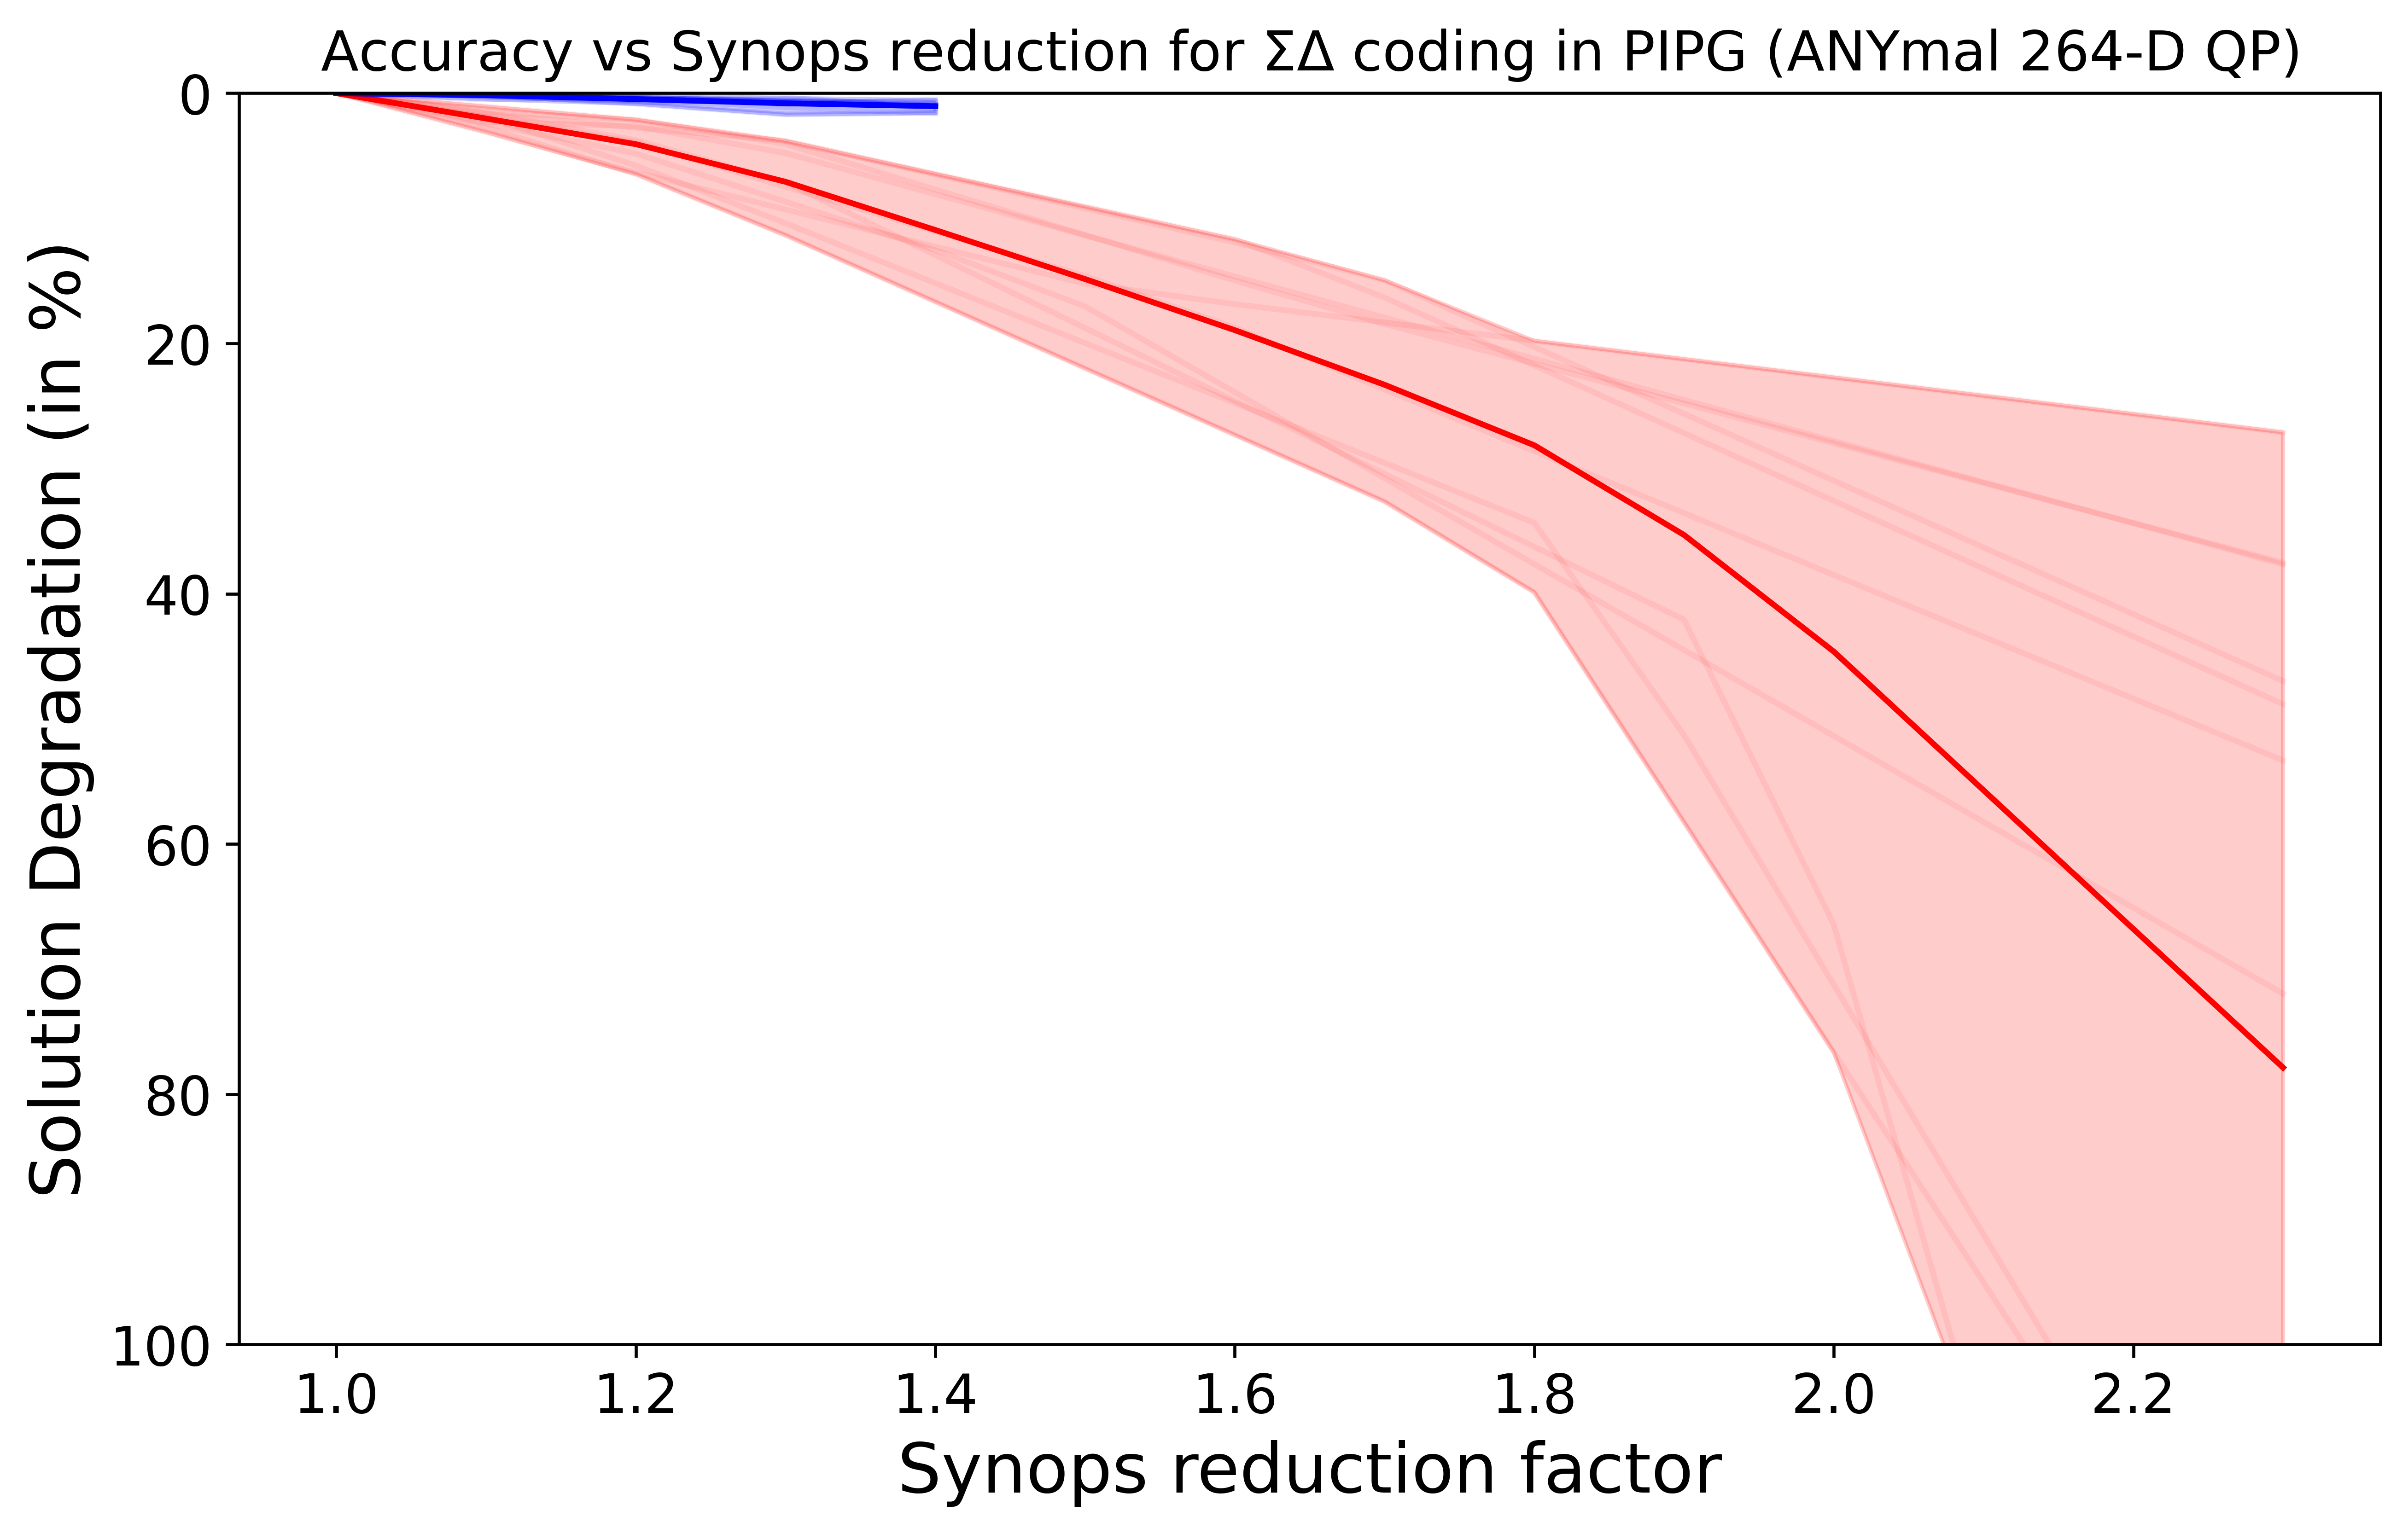

In [14]:
acc_ct_data = np.array(resampled_multi_prob_accuracy_red_ct)
std_ct_acc = np.std(acc_ct_data, axis=0)
mean_ct_acc = np.mean(acc_ct_data, axis=0)
min_ct_acc = np.min(acc_ct_data, axis=0)
max_ct_acc = np.max(acc_ct_data, axis=0) 

acc_at_data = np.array(resampled_multi_prob_accuracy_red_at)
std_at_acc = np.std(acc_at_data, axis=0)
mean_at_acc = np.mean(acc_at_data, axis=0)
min_at_acc = np.min(acc_at_data, axis=0)
max_at_acc = np.max(acc_at_data, axis=0) 


fig,ax = plt.subplots(figsize=(10, 6), dpi=600)
plt.rcParams.update({'font.size': 12})
plt.title("Accuracy vs Synops reduction for $ \Sigma \Delta $ coding in PIPG (ANYmal 264-D QP)")
for accu_ct in resampled_multi_prob_accuracy_red_ct:
    ax.plot(x_axis_ct, accu_ct, color="red", alpha=0.01)
ax.plot(x_axis_ct, mean_ct_acc, color="red")
ax.fill_between(x_axis_ct, min_ct_acc, max_ct_acc, color='red', alpha=0.2)
ax.set_ylabel("Solution Degradation (in %)",color="black",fontsize=18)
ax.invert_yaxis()
ax.set_ylim(100,0)
for accu_at in resampled_multi_prob_accuracy_red_at:
    ax.plot(x_axis_at, accu_at, color="blue", alpha=0.01)
ax.plot(x_axis_at, mean_at_acc, color="blue")
ax.fill_between(x_axis_at, min_at_acc, max_at_acc, color='blue', alpha=0.2)
ax.set_xlabel("Synops reduction factor",fontsize=18)
# ax.legend(loc="center right")
plt.show()

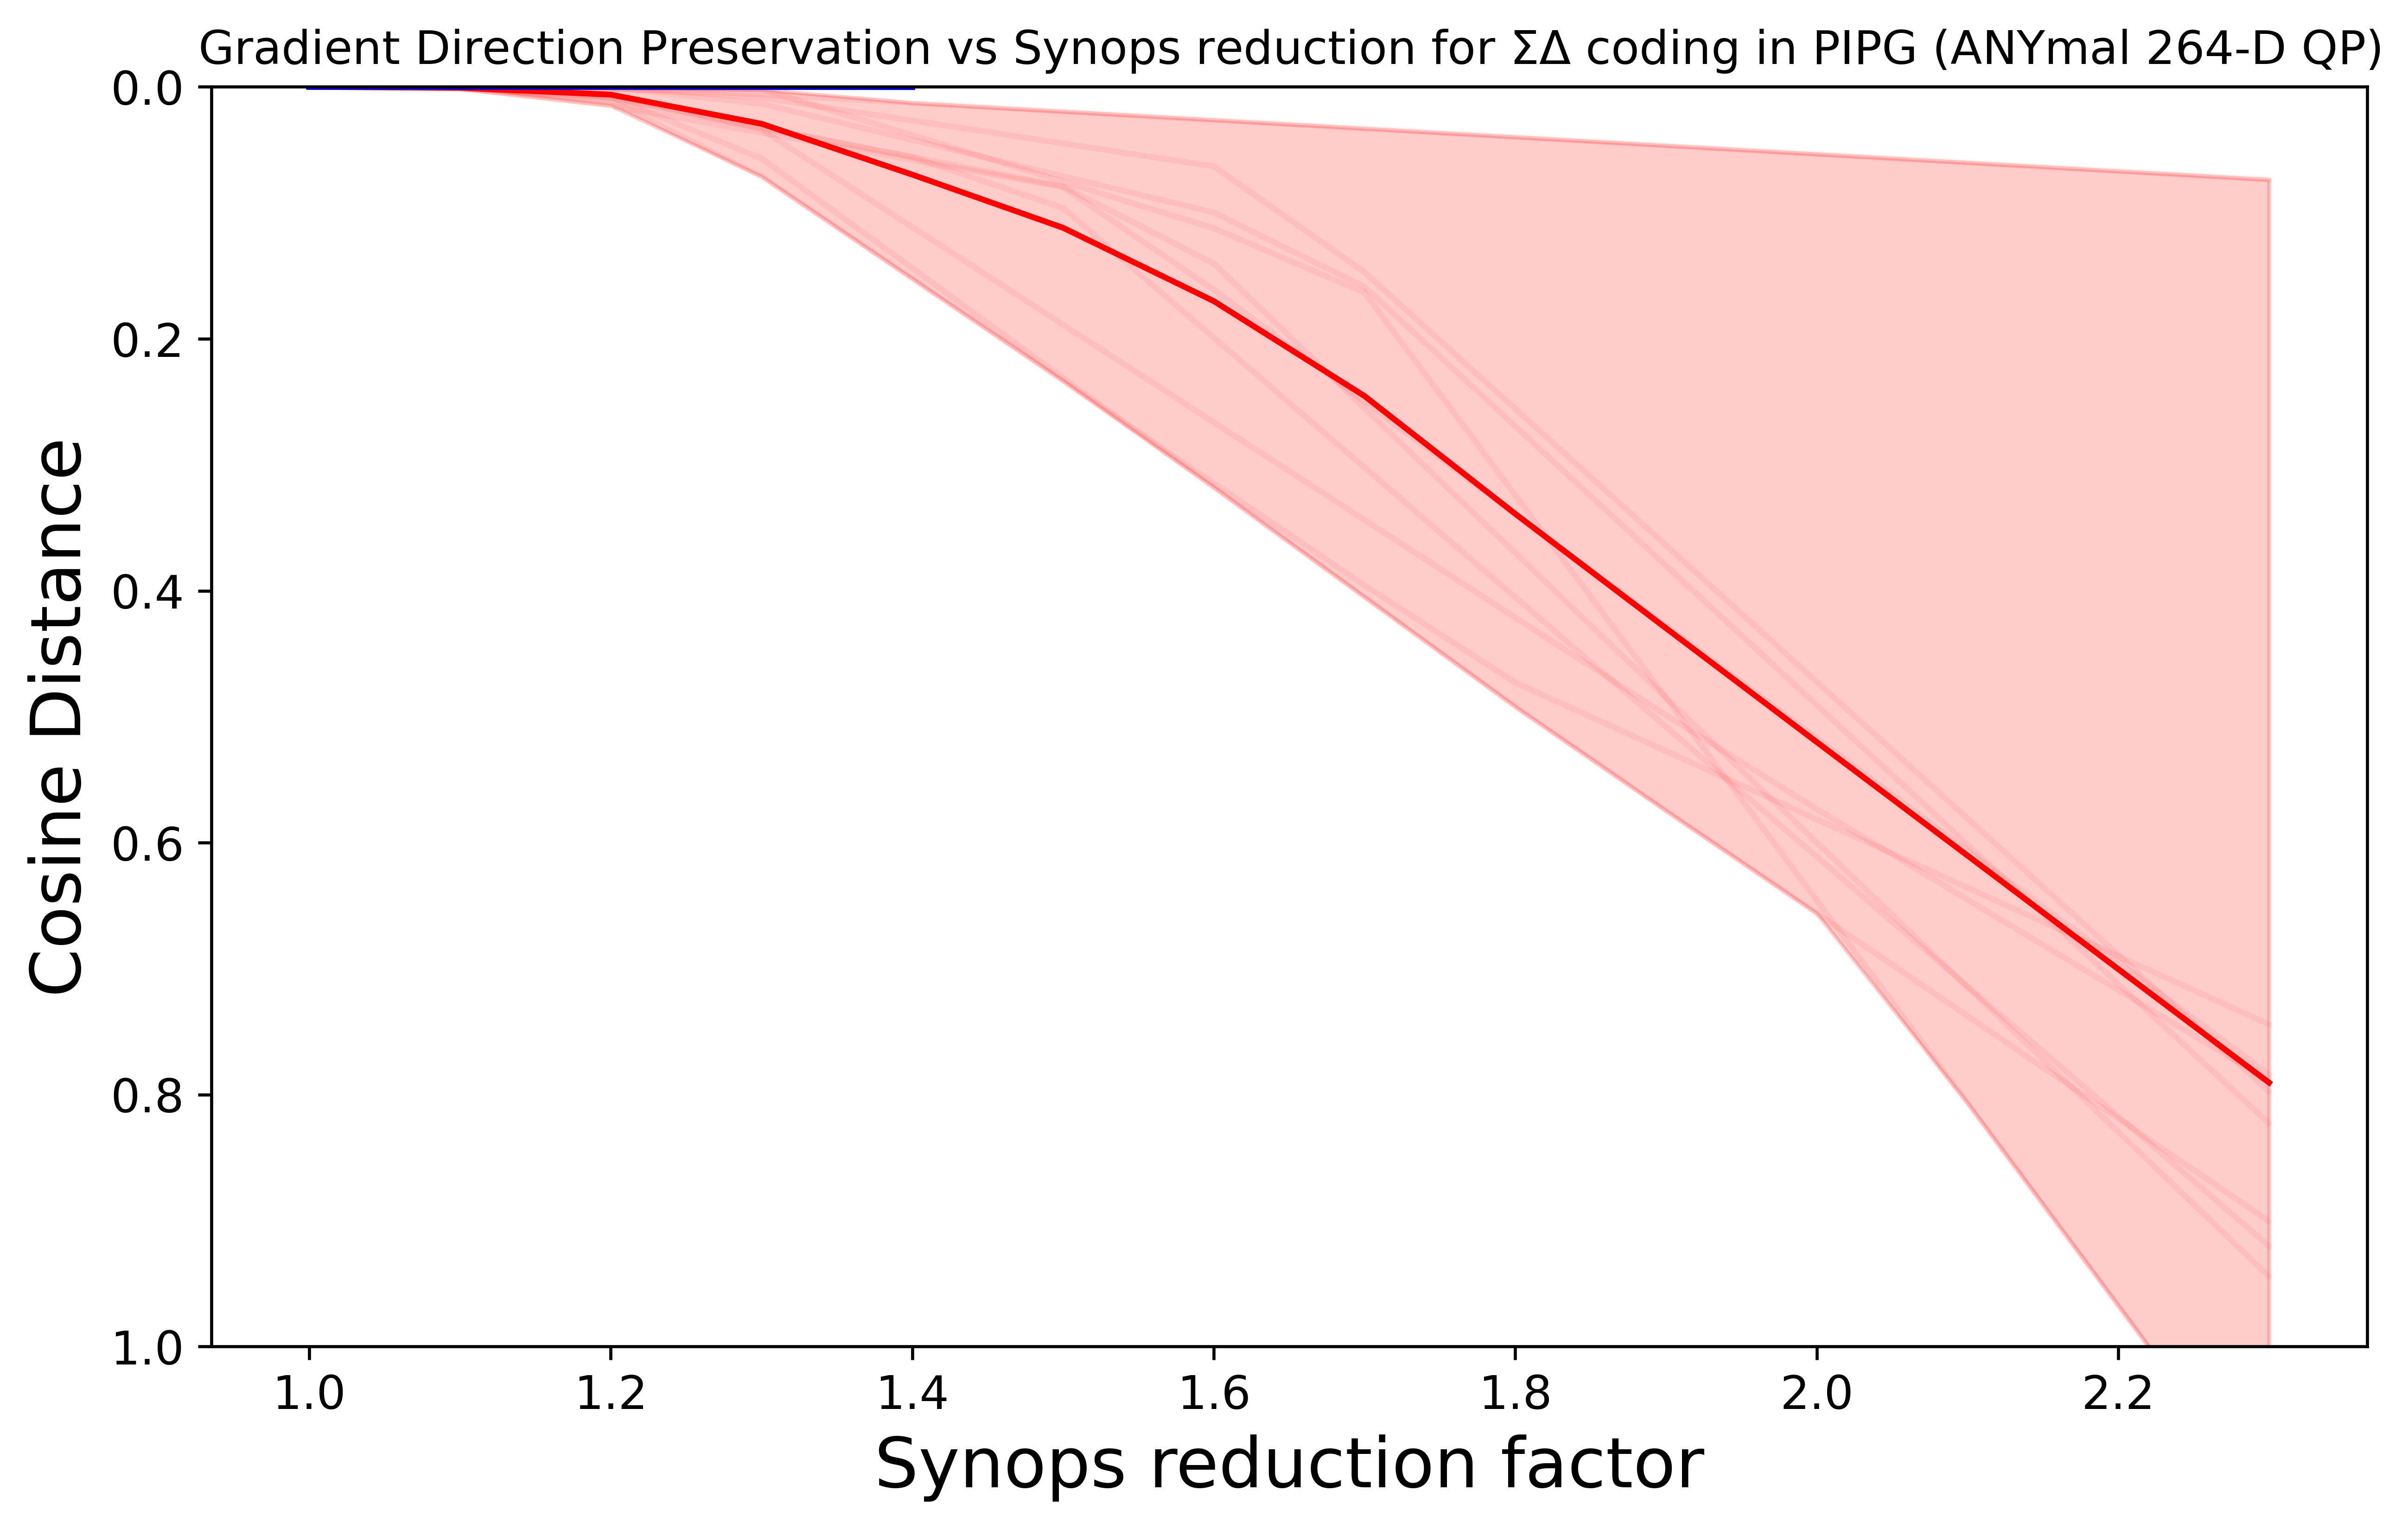

In [15]:
grad_ct_data = np.array(resampled_multi_prob_grad_dir_ct)
std_ct_grad = np.std(grad_ct_data, axis=0)
mean_ct_grad = np.mean(grad_ct_data, axis=0)
min_ct_grad = np.min(grad_ct_data, axis=0)
max_ct_grad = np.max(grad_ct_data, axis=0) 

grad_at_data = np.array(resampled_multi_prob_grad_dir_at)
std_at_grad = np.std(grad_at_data, axis=0)
mean_at_grad = np.mean(grad_at_data, axis=0)
min_at_grad = np.min(grad_at_data, axis=0)
max_at_grad = np.max(grad_at_data, axis=0) 

fig,ax = plt.subplots(figsize=(10, 6), dpi=600)
plt.rcParams.update({'font.size': 10})
plt.title("Gradient Direction Preservation vs Synops reduction for $ \Sigma \Delta $ coding in PIPG (ANYmal 264-D QP)")

for grad_ct in resampled_multi_prob_grad_dir_ct:
    ax.plot(x_axis_ct, grad_ct, color="red", alpha=0.01)

ax.plot(x_axis_ct, mean_ct_grad, color="red")
ax.fill_between(x_axis_ct, min_ct_grad, max_ct_grad, color='red', alpha=0.2)

ax.set_ylabel("Cosine Distance",color="black",fontsize=18)
ax.invert_yaxis()
ax.set_ylim(1, 0)

for grad_at in resampled_multi_prob_grad_dir_at:
    ax.plot(x_axis_at, grad_at, color="blue", alpha=0.01)
    
ax.plot(x_axis_at, mean_at_grad, color="blue")
ax.fill_between(x_axis_at, min_at_grad, max_at_grad, color='blue', alpha=0.2)   

ax.set_xlabel("Synops reduction factor",fontsize=18)
#ax.legend(loc="center right")
plt.show()

# Fixed point analysis

We plot the full-dataset histogram to see how the weights look after preconditioning

In [16]:
import pickle 
open_file = open('qp\data\problem_stats\weight_data_preconditioned_2000.pickle', "rb")
Q_pre_all, A_pre_all, p_pre_all = pickle.load(open_file)
open_file.close()
# Q_pre_all, A_pre_all, p_pre_all = np.array(Q_pre_all), np.array(A_pre_all), np.array(p_pre_all)

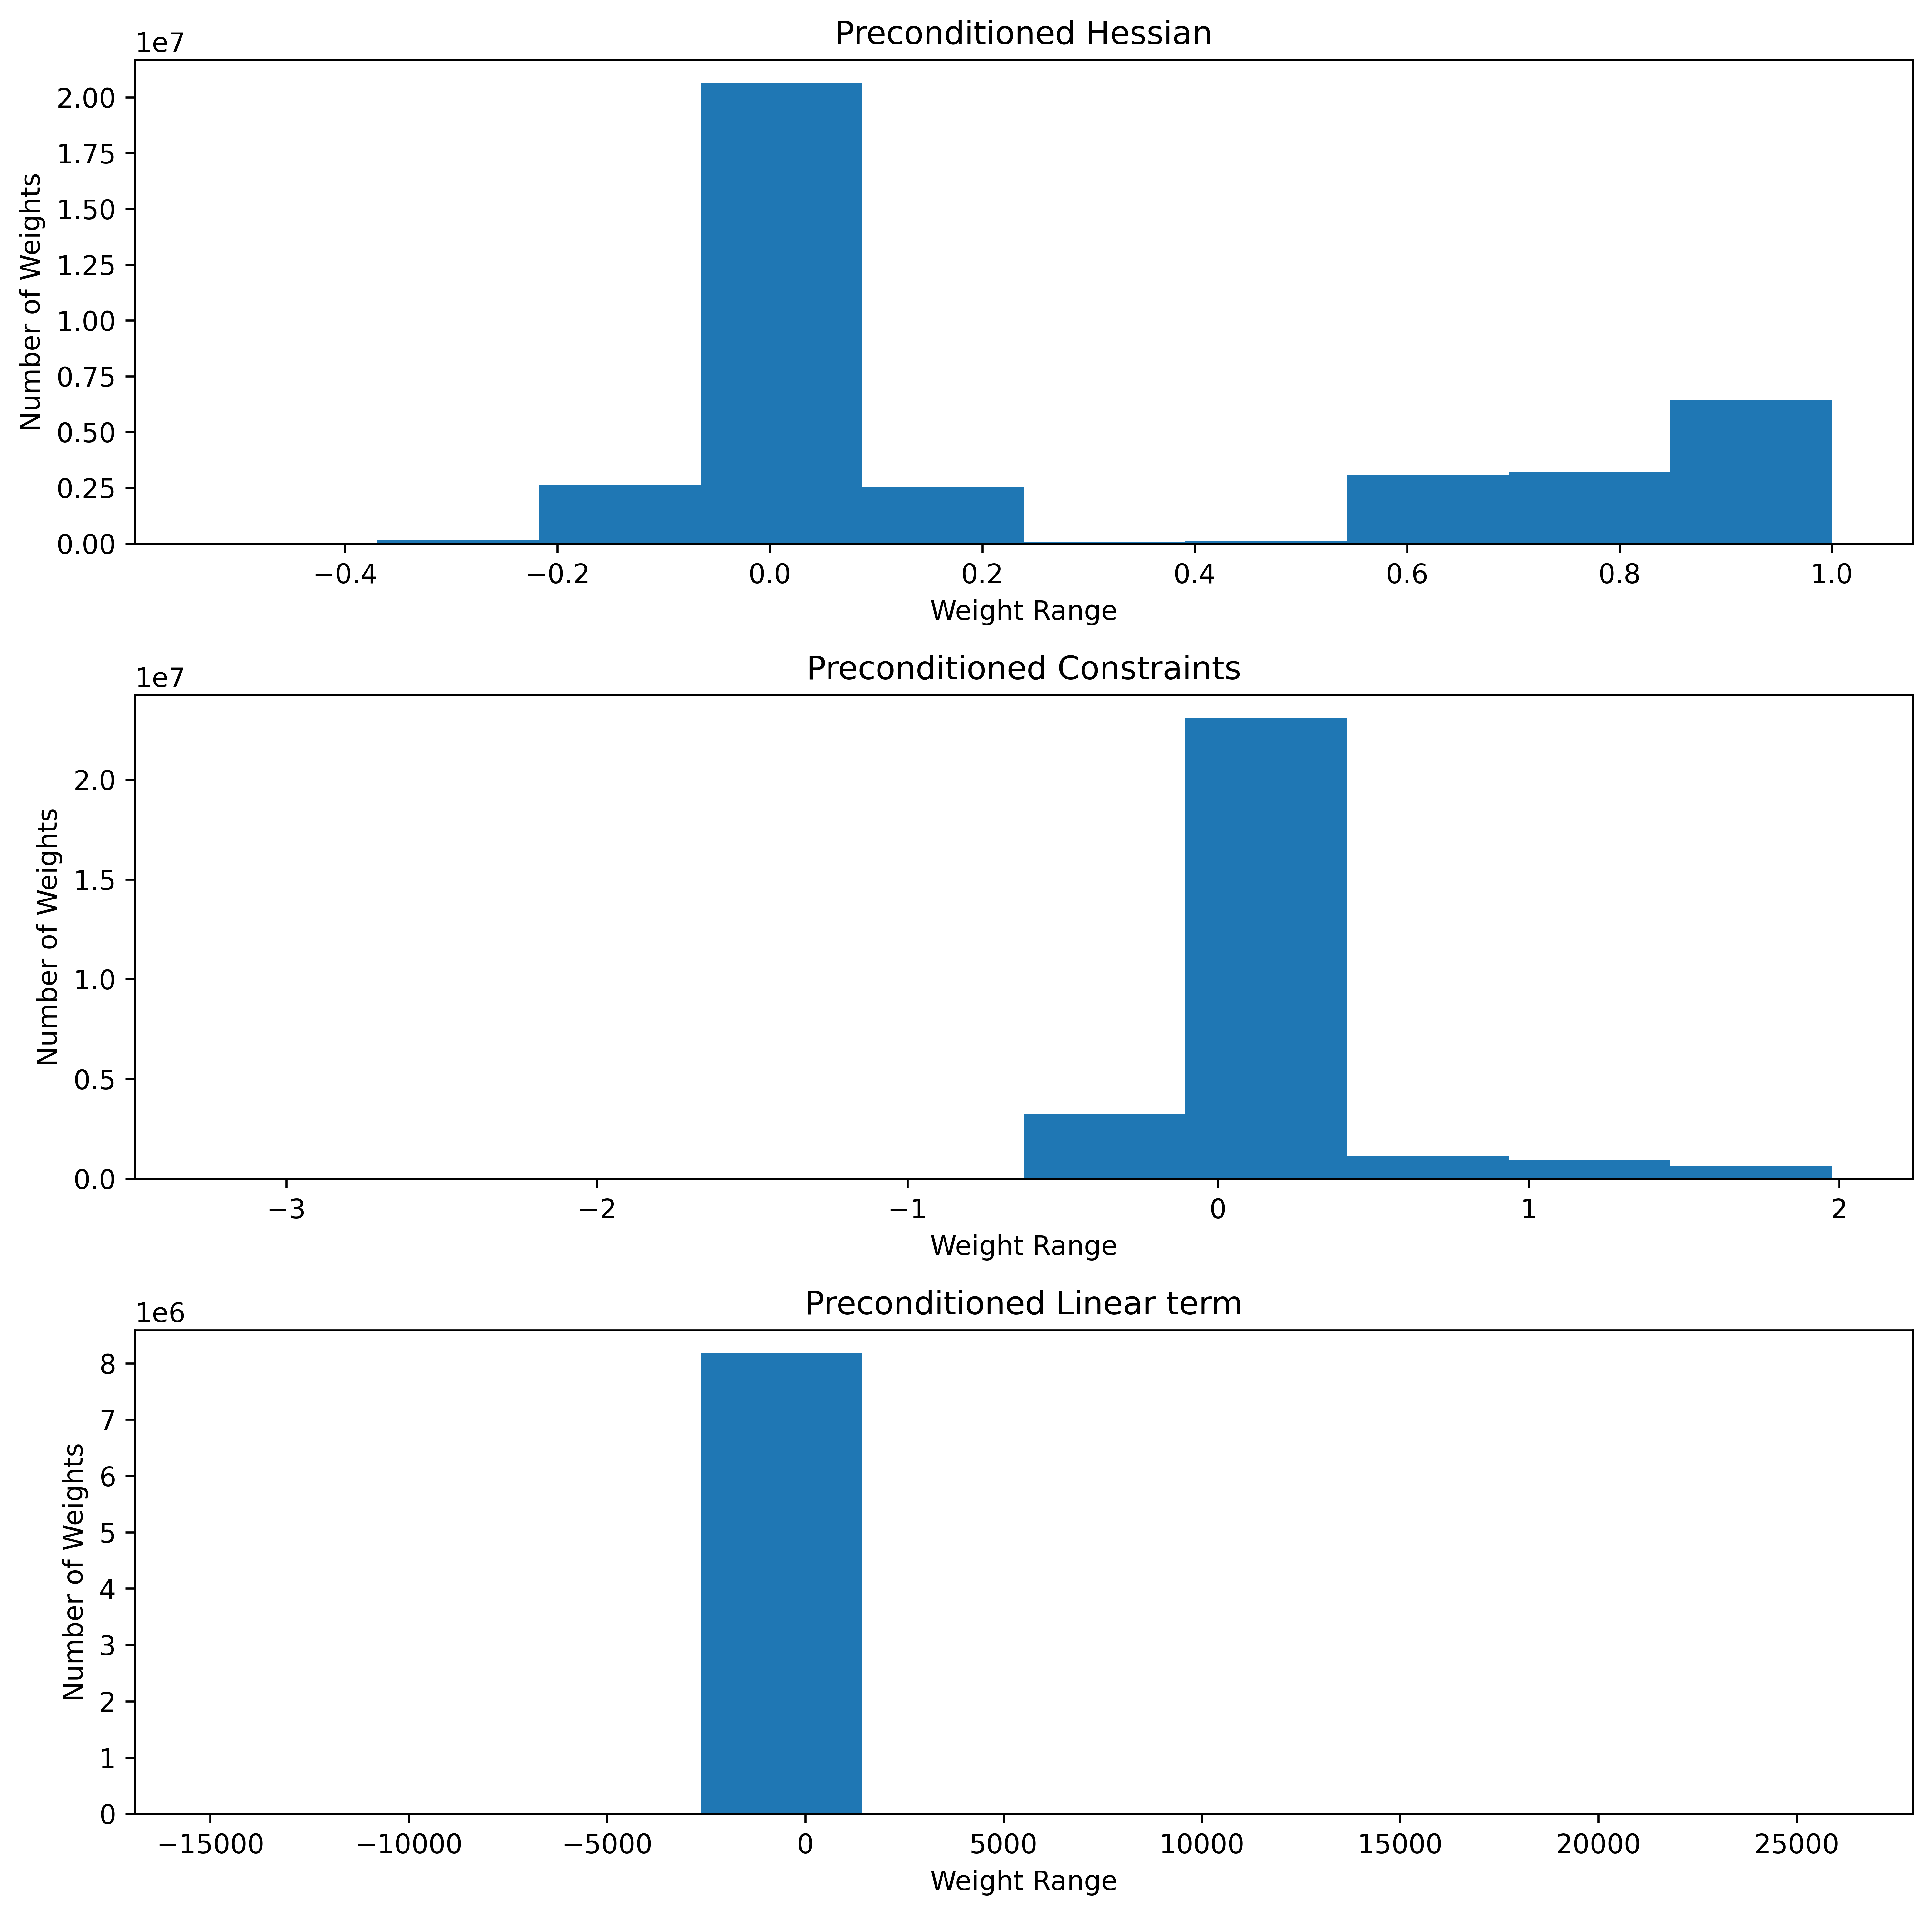

In [17]:
# Q_non_zero = Q[np.abs(Q)>0]
# A_non_zero = A[np.abs(A)>0]
# p_non_zero = p[np.abs(p)>0]

Q_pre_non_zero = np.concatenate(Q_pre_all, axis=0)
A_pre_non_zero = np.concatenate(A_pre_all, axis=0)
p_pre_non_zero = np.concatenate(p_pre_all, axis=0)

xaxes = 'Weight Range'
yaxes = 'Number of Weights'
# titles = ['Hessian','Preconditioned Hessian','Constraints','Preconditioned Constraints', 'linear term', 'Preconditioned Linear term'] 
titles = ['Preconditioned Hessian','Preconditioned Constraints', 'Preconditioned Linear term'] 

f,a = plt.subplots(3,1, figsize=(10, 10), dpi=600)
#plt.xscale('log')

a = a.ravel()
# data=[Q_non_zero,Q_pre_non_zero, A_non_zero, A_pre_non_zero, p_non_zero, p_pre_non_zero]
data=[Q_pre_non_zero, A_pre_non_zero, p_pre_non_zero]

bins = [2**x for x in range(-13,12)]
for idx,ax in enumerate(a):
    ax.hist(data[idx])
    ax.set_title(titles[idx])
    ax.set_xlabel(xaxes)
    ax.set_ylabel(yaxes)

plt.tight_layout()

# axs[0, 0].hist(Q_pre_non_zero, bins=bins)

# plt.xscale('log')
# plt.title("Weight Histogram for Q_pre matrix") 
# plt.show()
# print("Histogram values: {}".format(n))

In [18]:
ax.hist(data[1])

(array([6.0000000e+00, 4.3000000e+01, 2.7570000e+03, 1.3830000e+03,
        1.1665000e+04, 3.2364220e+06, 2.3083507e+07, 1.1203400e+06,
        9.4923600e+05, 6.2831200e+05]),
 array([-3.22682022, -2.70652735, -2.18623449, -1.66594162, -1.14564876,
        -0.62535589, -0.10506303,  0.41522983,  0.9355227 ,  1.45581556,
         1.97610843]),
 <BarContainer object of 10 artists>)

We next move on to the average behavior of our problems curated based on condition number

In [19]:
# stochastic rounding function for numpy arrays
def prob_round(x):
    sign = np.sign(x)
    x = abs(x)
    is_up = np.random.random(x.shape) < x-x.astype(int)
    return sign*(np.ceil(is_up*x) + np.floor(np.logical_not(is_up)*x))

In [20]:
def convert_to_fp(m_pre, man_bits):
    exp_1 = np.ceil(np.log2(np.max(np.abs(m_pre)))) - man_bits + 1 
    exp_2 = exp_1  - man_bits + 1 
    exp_3 = exp_2  - man_bits + 1
    exp_4 = exp_3  - man_bits + 1
    exp_5 = exp_4  - man_bits + 1
    
    mat_exp_1 =  (2**-exp_1)*((1*(np.abs(m_pre)>=2**exp_1))) #ul max(m_pre)
#     mat_exp_2 = (2**-exp_2)*(1*(np.abs(m_pre)<2**exp_1) * (1*(np.abs(m_pre)>=2**exp_2))) #ul 2**exp_1
#     mat_exp_3 = (2**-exp_3)*(1*(np.abs(m_pre)<2**exp_2) * (1*(np.abs(m_pre)>=2**exp_3))) #ul 2**exp_2
#     mat_exp_4 = (2**-exp_4)*(1*(np.abs(m_pre)<2**exp_3) * (1*(np.abs(m_pre)>=2**exp_4))) #ul 2**exp_3


#     m_pre_exp_mat = mat_exp_1 + mat_exp_2 + mat_exp_3 + mat_exp_4
    m_pre_exp_mat = mat_exp_1 
    m_pre_man = np.round(m_pre*m_pre_exp_mat)

    # performing this atrocity because of numpy type error, to be fixed later but behavior is as intended
    mat_exp_1 =  (2**exp_1)*((1*(np.abs(m_pre)>=2**exp_1))) #ul max(m_pre)
#     mat_exp_2 = (2**exp_2)*(1*(np.abs(m_pre)<2**exp_1) * (1*(np.abs(m_pre)>=2**exp_2))) #ul 2**exp_1
#     mat_exp_3 = (2**exp_3)*(1*(np.abs(m_pre)<2**exp_2) * (1*(np.abs(m_pre)>=2**exp_3))) #ul 2**exp_2
#     mat_exp_4 = (2**exp_4)*(1*(np.abs(m_pre)<2**exp_3) * (1*(np.abs(m_pre)>=2**exp_4))) #ul 2**exp_3

#     m_pre_exp_mat = mat_exp_1 + mat_exp_2 + mat_exp_3 + mat_exp_4 
    m_pre_exp_mat = mat_exp_1
    m_pre_fp = m_pre_man*(m_pre_exp_mat)
    return m_pre_fp

In [21]:
scale = "small"
path = "qp/data/anymal_"+scale+"_scale/"
file_list=os.listdir(path)

multi_prob_cons_vio_fp = []
weight_bits = [8, 16, 24, 32]
alpha_decay_indices_list = [35, 100, 200, 350, 600, 900]
beta_growth_indices_list = [1, 3, 7, 15, 31, 63, 127, 255, 511, 900]

k_max = 1000

for file in file_list:
    a = np.load(path+file)
    Q, A, p, k = [a[i] for i in a] 
    
    # OSQP reference
    Q_ref = sparse.csc_matrix(Q)
    A_ref = sparse.csc_matrix(A)
    l_eq = k
    u_eq = k
    #create OSQP object
    prob = osqp.OSQP()
    prob.setup(Q_ref, p, A_ref, l_eq, u_eq, warm_start=False)
    res = prob.solve()
    opt_sol = res.x.reshape((res.x.shape[0], 1))
    opt_objective =  res.info.obj_val
    
    toc = time.time()
    
    # matrix preconditioning
    pre_mat_Q, _ = ruiz_equilibriation(Q, 20)
    Q_pre = pre_mat_Q@Q@pre_mat_Q
    p_pre = pre_mat_Q@p

    pre_mat_A, _ = ruiz_equilibriation(A, 10)
    A_pre = pre_mat_A@A@pre_mat_Q
    k_pre = pre_mat_A@k
    
    ref_grad = -(Q@opt_sol  + p) 

    err_sol_fp = dict()
    grad_sim = dict()
    err_sol_percent_fp = dict()
    fp_last_it = dict()
    cons_vio = dict()
    
    for bits in weight_bits:

        p_pre_exp = 0

        # Intial beta mantissa 
        beta_man = 1
        alpha_man = 5
        # Quasi-static Variables
        alpha_exp = -3
        beta_exp = -7 

        # fixed-point PIPG
        Q_pre_fp = convert_to_fp(Q_pre, bits)
        A_pre_fp = convert_to_fp(A_pre, bits)
        p_pre_fp = convert_to_fp(p_pre, 24)
        beta_fp = beta_man*2**(beta_exp)
        alpha_fp = alpha_man*2**(alpha_exp)

        # PIPG init
        np.random.seed(10)
        w_fp = np.zeros((A.shape[0],1)) 
        x_fp = np.zeros((A.shape[1],1))
        v_fp= np.zeros((A.shape[0],1)) 

        sol_fp = []
        constraint_sat = []
        cost = []

        alpha_decay_indices_list = [35, 100, 200, 350, 600, 900]
        beta_growth_indices_list = [1, 3, 7, 15, 31, 63, 127, 255, 511, 900]

        # alpha_decay_indices_list = [70, 200, 400]
        # beta_growth_indices_list = [2, 6, 14, 30, 62, 124, 255, 512]

        k_max=1000

        toc = time.time()
        for i in range(k_max):
            if (i in alpha_decay_indices_list ):
                alpha_fp/=2
            if (i in beta_growth_indices_list):
                beta_fp*=2

            x_fp = x_fp - alpha_fp * (Q_pre_fp@x_fp + p_pre_fp +  A_pre_fp.T@v_fp )
            gamma =  beta_fp * (A_pre_fp@x_fp)
            w_fp += gamma

            v_fp = w_fp + gamma
            #cost.append(np.abs((z.T@H_pre@z/2 + h_pre.T@z) - opt_objective)/np.abs(opt_objective)*100)
            sol_fp.append(pre_mat_Q@x_fp)
#             constraint_sat.append(np.linalg.norm(G_pre@z - g_pre))
            grad_sol = -(Q@(pre_mat_Q@x_fp) + p) 

        fp_last_it[bits] = pre_mat_Q@x_fp
        err_sol_percent_fp[bits] = [np.linalg.norm(opt_sol - s)/np.linalg.norm(opt_sol)*100 for s in sol_fp] 
        err_sol_fp[bits] = [np.linalg.norm(opt_sol - s) for s in sol_fp]
        cons_vio[bits] = [np.linalg.norm(A@s - k) for s in sol_fp]
        grad_sim[bits] = distance.cosine(ref_grad.reshape(ref_grad.shape[0],), grad_sol.reshape(grad_sol.shape[0],))
    multi_prob_cons_vio_fp.append(cons_vio)

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 264, constraints m = 144
          nnz(P) + nnz(A) = 1264
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: off, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.0288e+04   3.33e-02   1.81e+00   1.00e-01   9.15e-04s
  25  -1.6021e+04   2.90e-06   8.49e-06   1.00e-01   1.73e-03s

status:               solved
number of ite

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 264, constraints m = 144
          nnz(P) + nnz(A) = 1471
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: off, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -3.2164e+05   1.51e-01   9.35e+00   1.00e-01   5.62e-04s
  25  -5.0055e+05   1.75e-05   4.49e-05   1.00e-01   2.15e-03s

status:               solved
number of ite

In [22]:
data, std_err, mean_err, min_err, max_err = dict(), dict(), dict(), dict(), dict()
multi_prob_cons_vio_by_bits = []
for bits in weight_bits:
    for problem in multi_prob_cons_vio_fp:
        multi_prob_cons_vio_by_bits.append(problem[bits])
    data[bits] = np.array(multi_prob_cons_vio_by_bits)
    std_err[bits] = np.std(data[bits], axis=0)
    mean_err[bits] = np.mean(data[bits], axis=0)
    min_err[bits] = np.min(data[bits], axis=0)
    max_err[bits] = np.max(data[bits], axis=0) 
    multi_prob_cons_vio_by_bits = []

In [23]:
fig,ax = plt.subplots(figsize=(10, 6), dpi=1000)
plt.rcParams.update({'font.size': 14})
plt.title("Constraint Violation using PIPG for different fixed-point settings (264-D ANYmal QP)", fontsize=14)
colors = ['red', 'orange', 'blue', 'green']

ax.set_ylabel("Constraint Violation \n $ ||Ax-k||_2} $",color="black",fontsize=18)
ax.set_yscale('log')
# set x-axis label
ax.set_xlabel("Iterations",fontsize=18)

count = 0
for bits in weight_bits:
    for single_problem_data in data[bits]:
        ax.plot(single_problem_data, color=colors[count], alpha=0.1)
    ax.fill_between(range(0,k_max), min_err[bits], max_err[bits], color=colors[count], alpha=0.05)
    ax.plot(mean_err[bits], color=colors[count], label=str(bits) + " bits" )
    count+=1

    ax.legend(loc="lower left", fontsize='medium')


# ax.set_ylabel("Constraint Violation \n $ ||Ax-k||} $",color="black",fontsize=18)
# ax.set_yscale('log')
# # set x-axis label
# ax.set_xlabel("Iterations",fontsize=18)



### How to learn more?

Watch this [space](https://github.com/lava-nc/lava-optimization) to learn about upcoming developments to the QP solver and the optimization toolbox in Lava in general. 

If you want to find out more about the implementation of the QP solver, have a look at the [Lava documentation](https://lava-nc.org/ "Lava Documentation") or dive into the [source code](https://github.com/lava-nc/lava-optimization/tree/main/src/lava/lib/optimization/solvers/qp
"QP source code").
To receive regular updates on the latest developments and releases of the Lava Software Framework please subscribe to the [INRC newsletter](http://eepurl.com/hJCyhb "INRC Newsletter").